# Nerual Network

A nerual network is a parametric model -- just like linear regression and logistic regression, which maps input to output and depends on many parameters.
But it is much more ``expressive'' than linear models, as it can represent complex non-linear relationships between input and output.

For the feedforward neural network, also known as the multilayer perceptron (MLP), the model is a composition of linear transformations and non-linear activation functions.

Mathematically, the model can be written as:

$$
\begin{aligned}
h_1 &= \sigma(W_1 x + b_1) \\
h_2 &= \sigma(W_2 h_1 + b_2) \\
\vdots \\
y &= \sigma(W_{L} h_{L-1} + b_{L})
\end{aligned}
$$

where $x$ is the input in $\mathbb{R}^d$,$y$ is the output, $W_i$ and $b_i$ are the `weight` and `bias` of the affine transformation in layer i, 
$\sigma$ is the activation function, and $L$ is the number of layers.

The typical workflow of training a neural network is similar to logistic regression: define the model, define the loss function, and optimize the loss function.

[interative visualization of neural network](https://playground.tensorflow.org/).

In the following, we will compare the performance of a neural network and a logistic regression model on the hand written digit classification task.

In [4]:
import numpy as np
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# Transform from torch tensor to numpy array
to_numpy_transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.numpy()
])

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=to_numpy_transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=to_numpy_transform)

# concatenate the train and test sets, shape = (batch,28,28)
X = np.concatenate([mnist_train.data, mnist_test.data], axis=0)
y = np.concatenate([mnist_train.targets, mnist_test.targets], axis=0)

# Normalize the data
X = X.reshape(-1, 784)  #shape = (batch, 784)
X = X / 255.0  # normalize to [0,1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)  # Approximately 10k test samples


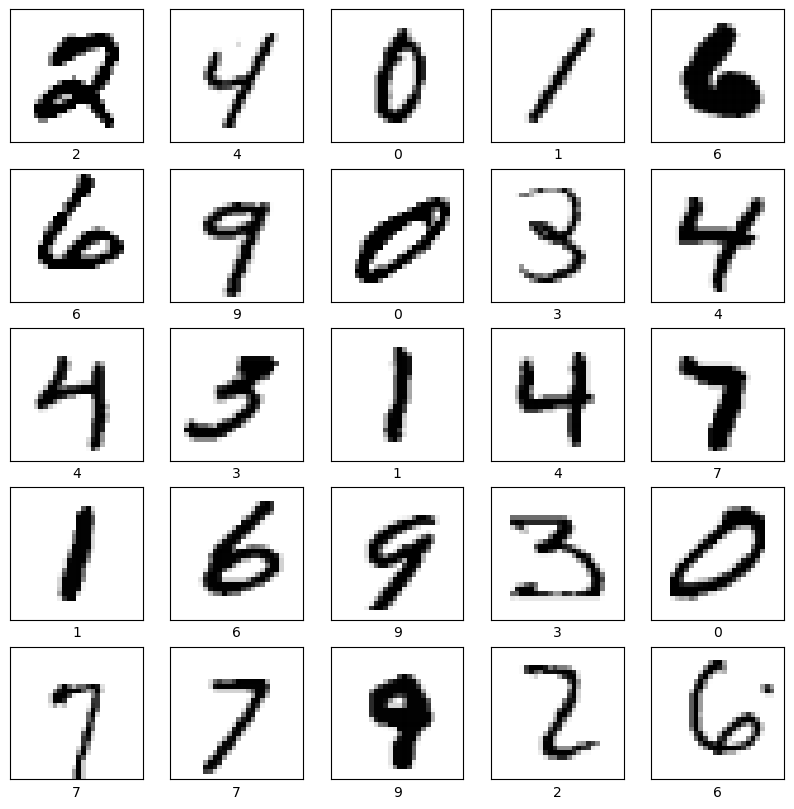

In [5]:
# visualize example images
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # black background
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(y_train[i])

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Logistic Regression Model
model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial', random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Logistic Regression Accuracy: {accuracy * 100:.2f}%')


Logistic Regression Accuracy: 92.06%


In [6]:
from torch.utils.data import TensorDataset, DataLoader

# Convert arrays back to torch tensors for training in PyTorch
tensor_X_train = torch.Tensor(X_train).reshape(-1, 1, 28, 28)  # Reshape to (batch, channel, height, width)
tensor_y_train = torch.Tensor(y_train).to(torch.int64)
tensor_X_test = torch.Tensor(X_test).reshape(-1, 1, 28, 28)
tensor_y_test = torch.Tensor(y_test).to(torch.int64)

# Create TensorDatasets
train_dataset = TensorDataset(tensor_X_train, tensor_y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score

# define model
class NeuralNet(nn.Module):
    def __init__(self, width=64):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.width = width
        self.layers = nn.Sequential(
            nn.Linear(28*28, self.width),
            nn.Tanh(),
            nn.Linear(self.width, self.width),
            nn.Tanh(),
            nn.Linear(self.width, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        prob = nn.functional.softmax(logits, dim=1)
        return prob

model = NeuralNet().cuda()

# Loss and Optimizer
bceloss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

    

# Compute accuracy
def evaluate(loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Run training
n_epoch = 10
for epoch in range(n_epoch): 
    model.train()
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = bceloss(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    accuracy = evaluate(test_loader)
    print(f'Epoch {epoch+1}, loss: {loss.item():.4f}, test accuracy: {accuracy:.2f}%')

# Evaluate the final accuracy
final_accuracy = evaluate(test_loader)
print(f'Test Accuracy: {final_accuracy:.2f}%')


Epoch 1, loss: 1.5260, test accuracy: 93.39%
Epoch 2, loss: 1.5224, test accuracy: 94.47%
Epoch 3, loss: 1.5485, test accuracy: 95.75%
Epoch 4, loss: 1.4642, test accuracy: 95.88%
Epoch 5, loss: 1.4955, test accuracy: 96.49%
Epoch 6, loss: 1.4915, test accuracy: 96.67%
Epoch 7, loss: 1.4613, test accuracy: 96.68%
Epoch 8, loss: 1.4937, test accuracy: 96.72%
Epoch 9, loss: 1.4735, test accuracy: 96.85%
Epoch 10, loss: 1.4636, test accuracy: 96.97%
Test Accuracy: 96.97%
